**import libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

**Helper Functions**

In [ ]:
def zero_order_hold(x, t_original, t_recon):
    idx = np.searchsorted(t_original, t_recon, side="left")
    idx = np.clip(idx, 0, len(x)-1)
    return x[idx]

def linear_interp(x, t_original, t_recon):
    return np.interp(t_recon, t_original, x)

def mse(x1, x2):
    return np.mean((x1 - x2)**2)

**Load your custom speech file**

In [ ]:
filename = "/content/drive/MyDrive/dl lab/Chorus.wav"
fs, orig_signal = wavfile.read(filename)

In [ ]:
# If stereo, convert to mono
if len(orig_signal.shape) == 2:
    orig_signal = orig_signal.mean(axis=1)

# Normalize if it's integer type
if orig_signal.dtype != np.float32 and orig_signal.dtype != np.float64:
    orig_signal = orig_signal.astype(np.float32) / np.max(np.abs(orig_signal))

duration = len(orig_signal) / fs
t = np.linspace(0, duration, len(orig_signal), endpoint=False)

**Plot original speech**

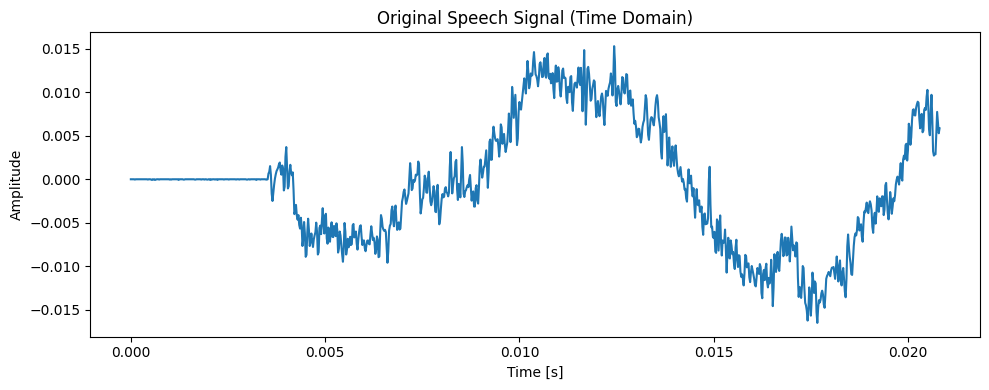

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(t[:1000], orig_signal[:1000])
plt.title("Original Speech Signal (Time Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

**1) Sampling & Reconstruction**

In [ ]:
sampling_rates = [8000, 16000, fs]  # Include original sampling rate
sampled_signals = {}
sampled_times = {}

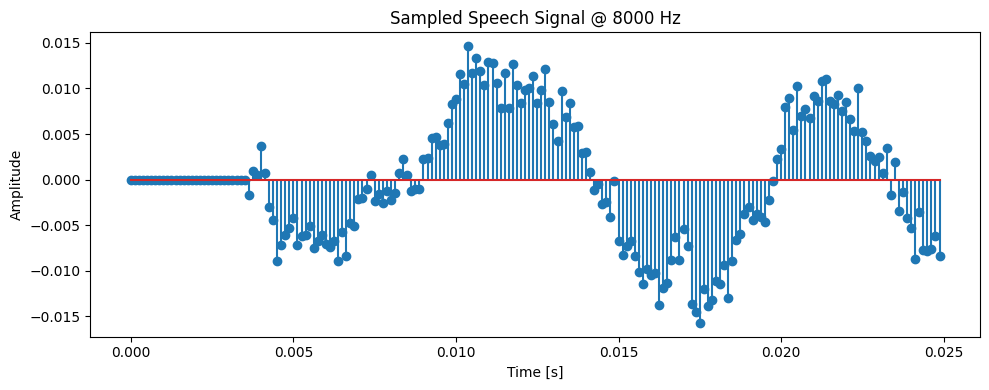

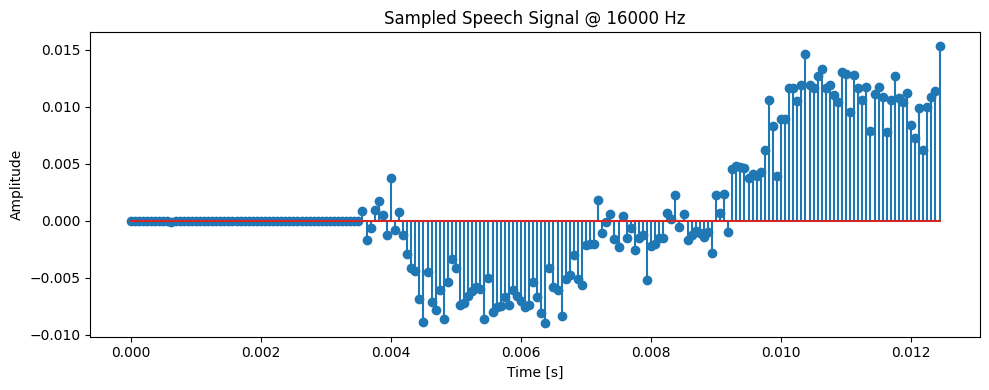

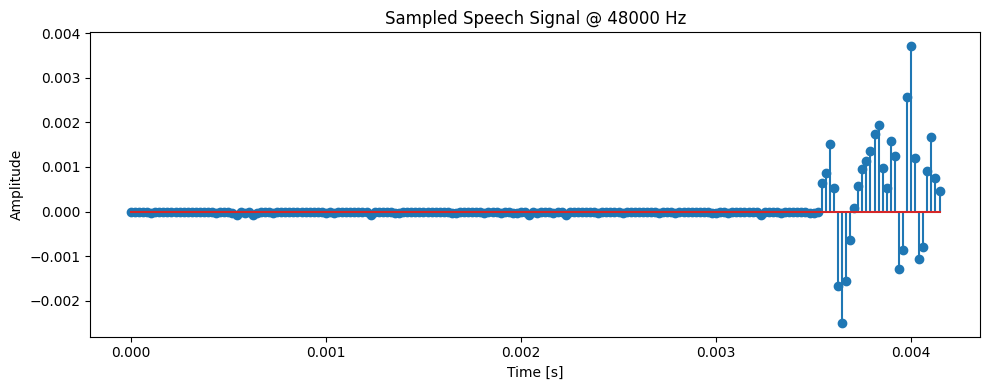

In [ ]:
for sr in sampling_rates:
    step = max(1, int(fs / sr))  # ensure step >= 1
    sampled_signals[sr] = orig_signal[::step]
    sampled_times[sr] = t[::step]

    n_points = min(200, len(sampled_times[sr]))  # avoid exceeding array length
    plt.figure(figsize=(10, 4))
    plt.stem(sampled_times[sr][:n_points], sampled_signals[sr][:n_points])
    plt.title(f"Sampled Speech Signal @ {sr} Hz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

**Reconstruction & MSE**


Sampling Rate: 8000 Hz
  MSE (ZOH): 0.007864
  MSE (Linear): 0.001760


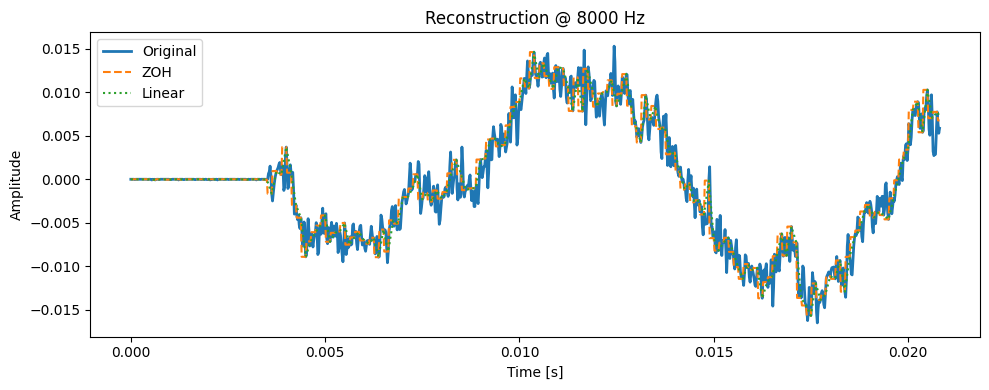


Sampling Rate: 16000 Hz
  MSE (ZOH): 0.002101
  MSE (Linear): 0.000362


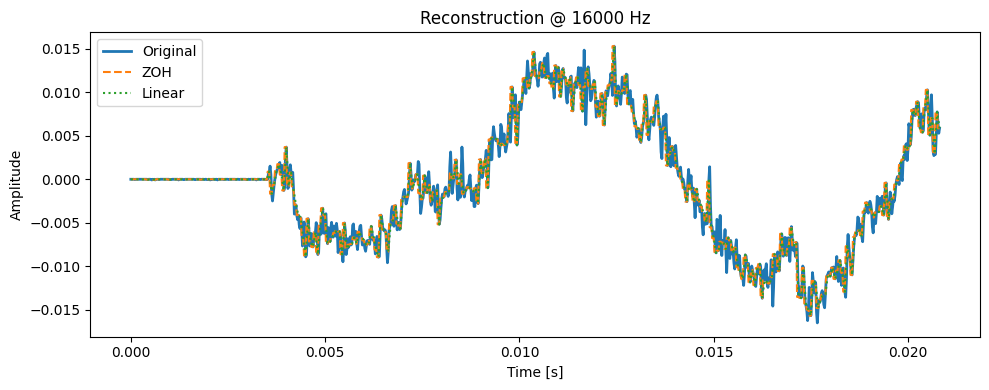


Sampling Rate: 48000 Hz
  MSE (ZOH): 0.000000
  MSE (Linear): 0.000000


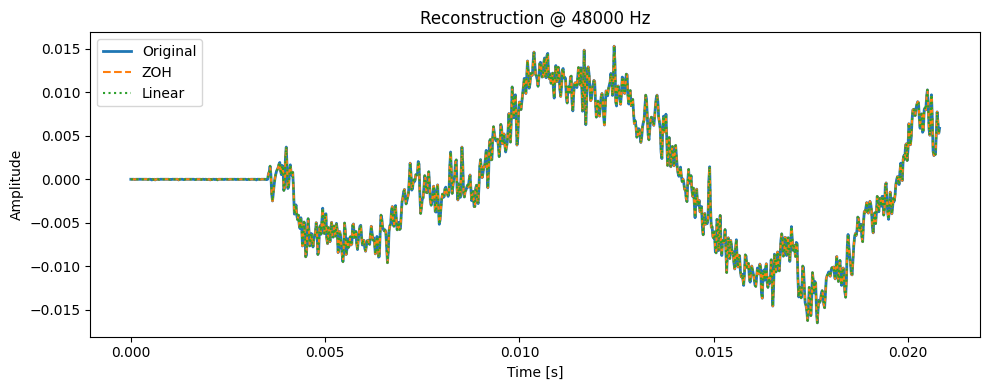

In [ ]:
for sr in sampling_rates:
    t_recon = t
    zoh_signal = zero_order_hold(sampled_signals[sr], sampled_times[sr], t_recon)
    lin_signal = linear_interp(sampled_signals[sr], sampled_times[sr], t_recon)

    mse_zoh = mse(orig_signal, zoh_signal)
    mse_lin = mse(orig_signal, lin_signal)

    print(f"\nSampling Rate: {sr} Hz")
    print(f"  MSE (ZOH): {mse_zoh:.6f}")
    print(f"  MSE (Linear): {mse_lin:.6f}")

    plt.figure(figsize=(10, 4))
    plt.plot(t[:1000], orig_signal[:1000], label="Original", lw=2)
    plt.plot(t[:1000], zoh_signal[:1000], "--", label="ZOH")
    plt.plot(t[:1000], lin_signal[:1000], ":", label="Linear")
    plt.title(f"Reconstruction @ {sr} Hz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

**2) Source-Filter Model**

In [ ]:
pitch = 100  # Hz
source = signal.square(2*np.pi*pitch*t) * 0.5

**Filter: vocal tract (formants)**

In [ ]:
formants = [500, 1500, 2500]  # Hz
b = [1.0]
a = [1.0]
for f in formants:
    r = np.exp(-np.pi*f/fs)
    theta = 2*np.pi*f/fs
    a = np.convolve(a, [1, -2*r*np.cos(theta), r**2])

speech = signal.lfilter(b, a, source)

**Plot source-filter**

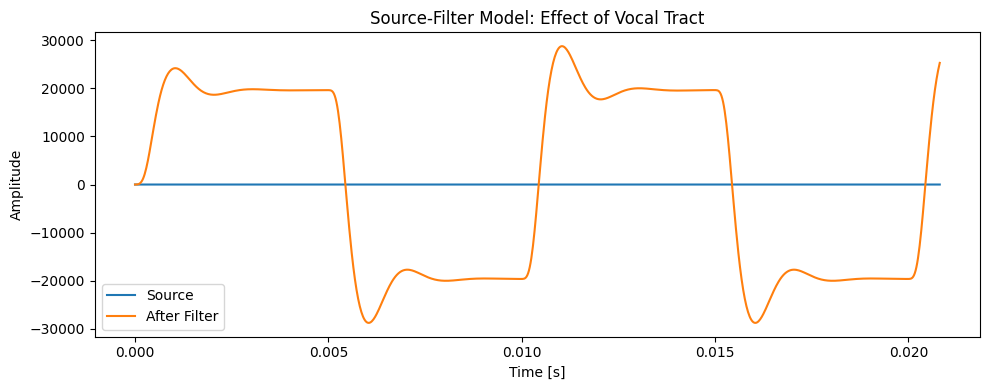

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(t[:1000], source[:1000], label="Source")
plt.plot(t[:1000], speech[:1000], label="After Filter")
plt.title("Source-Filter Model: Effect of Vocal Tract")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

**Sample and reconstruct source-filter speech**


[Source-Filter] Sampling Rate: 8000 Hz
  MSE (ZOH): 2759594.752014
  MSE (Linear): 17815.267408


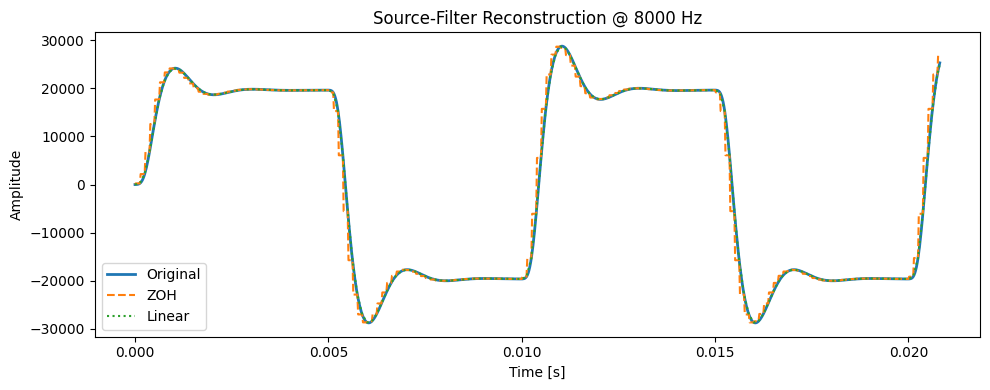


[Source-Filter] Sampling Rate: 16000 Hz
  MSE (ZOH): 505086.263646
  MSE (Linear): 1123.225082


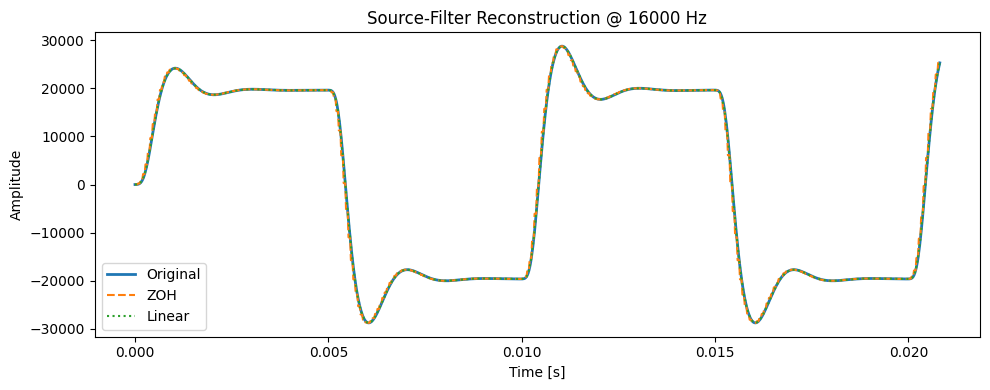


[Source-Filter] Sampling Rate: 48000 Hz
  MSE (ZOH): 0.000000
  MSE (Linear): 0.000000


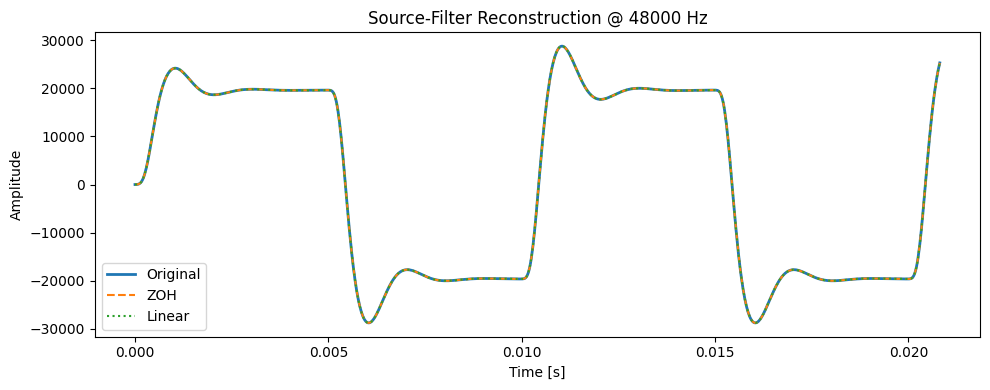

In [ ]:
for sr in sampling_rates:
    step = max(1, int(fs/sr))
    samp_sig = speech[::step]
    samp_time = t[::step]
    t_recon = t

    rec_zoh = zero_order_hold(samp_sig, samp_time, t_recon)
    rec_lin = linear_interp(samp_sig, samp_time, t_recon)

    mse_zoh = mse(speech, rec_zoh)
    mse_lin = mse(speech, rec_lin)

    print(f"\n[Source-Filter] Sampling Rate: {sr} Hz")
    print(f"  MSE (ZOH): {mse_zoh:.6f}")
    print(f"  MSE (Linear): {mse_lin:.6f}")

    n_points = min(200, len(t))
    plt.figure(figsize=(10, 4))
    plt.plot(t[:1000], speech[:1000], label="Original", lw=2)
    plt.plot(t[:1000], rec_zoh[:1000], "--", label="ZOH")
    plt.plot(t[:1000], rec_lin[:1000], ":", label="Linear")
    plt.title(f"Source-Filter Reconstruction @ {sr} Hz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()